# [NTDS'18] Final project
[ntds'18]: https://github.com/mdeff/ntds_2018

* Team: `4` ([github repo](https://github.com/swouf/ntds_IMDb_team4))
* Dataset: `IMDb Films and Crew`

### Authors :
+ [Julien Berger](mailto:juliengaetan.berger@epfl.ch)
+ [Jérémy Jayet](mailto:jeremy.jayet@epfl.ch)
+ [Hana Samet](mailto:hana.samet@epfl.ch)
+ [Mathieu Shiva](mailto:mathieu.shiva@epfl.ch)

## 0 - Import packages and data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pygsp as pg
import networkx as nx
import logging
import json
import sys
#import seaborn as sns

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

import src.load_data as ldata

In [2]:
(movies,people,list_of_genres_id) = ldata.load_dataframes();

2019-01-12 10:42:52,284 | INFO : Data loaded !


In [6]:
movies.head(10)
movies['genres_names'].value_counts()

Drama              1207
Comedy             1042
Action              754
Adventure           339
Horror              300
Crime               195
Thriller            194
Animation           123
Fantasy             117
Romance             106
Science Fiction      96
Documentary          89
Family               56
Mystery              41
Music                34
Unknown              28
Western              27
History              25
War                  24
TV Movie              4
Foreign               2
Name: genres_names, dtype: int64

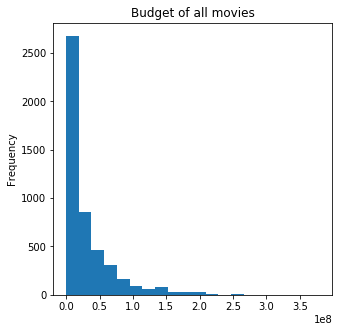

In [16]:
movies.budget.plot(kind='hist', bins = 20, figsize = (5,5))
plt.title('Budget of all movies')
plt.show()

C:\Users\lekil\Miniconda3\envs\Week_4\lib\site-packages\matplotlib\legend.py:1266: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


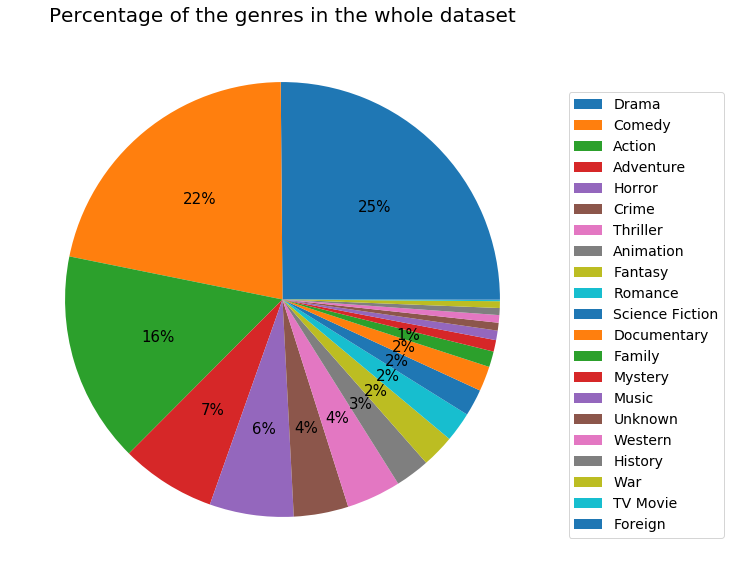

In [105]:
data=movies['genres'].value_counts()
data
plt.figure(figsize = (10,10))
plt.pie(data, autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',labeldistance=1.1,startangle=0,textprops={'fontsize': 15})
plt.title('Percentage of the genres in the whole dataset',fontsize=20)
plt.legend(data,labels=movies['genres_names'].value_counts().index, bbox_to_anchor=(0.9,0.80), bbox_transform=plt.gcf().transFigure,prop={'size': 14})
plt.show()

In [ ]:
#CODE TO GENERATE THE ADJACENCY MATRIX THAT CONNECTES MOVIES TOGETHER
#TAKE A LONG AMOUNT OF TIME, SO JUST USE adjacency_test=np.load('./data/adjacency_test_movies.npy')

#features_movies=ldata.load_features();
#adjacency_test=ldata.make_adjacency_from_feature_matrix(features_movies)
#adjacency_test

#The commented lines can be replaced by the line below --> the creation of the adjacency doesn't have to be done each time.
#adjacency_test=np.load('./data/adjacency_test_movies.npy')

#need to find a way to select only certain movies from the features ()

In [ ]:
adjacency=np.load('./data/adjacency_test_movies.npy')
#need at least two of the same actor
adjacency[adjacency <2]=0
plt.figure(figsize=(10, 10))
plt.spy(adjacency, markersize=0.1)
plt.title('adjacency matrix')

G_test = nx.from_numpy_matrix(adjacency)
nx.number_connected_components(G_test)
Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)

In [ ]:
coords_test = nx.spring_layout(Gc_test,k=0.03)  # Force-directed layout.
labels = movies['genres'].iloc[np.sort(nx.nodes(Gc_test))]
plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc_test, coords_test, node_size=10,node_color=labels, cmap='gist_ncar')
nx.draw_networkx_edges(Gc_test, coords_test, alpha=0.1, width=0.7)
plt.title('Giant component graph of genres')
plt.colorbar(im);
#Il faudrait faire une légende qui relie la couleur aux genres présents.

In [ ]:
numberOfDecades = 6

moviesFilteredByYears = []

for i in range(numberOfDecades):
    decade = 1960 + i*10
    decadeEnd = decade + 10
    moviesFilteredByYears.append(ldata.filter_movies_by_years(movies, pd.to_datetime(f'{decade}-01-01').date(), pd.to_datetime(f'{decadeEnd}-01-01').date()))

In [ ]:
#(adjacency, movies_by_budget) = ldata.make_budget_based_adjacency(movies);

adjacenciesFilteredByYears = []
moviesByBudgetFilteredByYears = []
genreOfMoviesFilteredByYears=[]
graphsFilteredByYears = []

for moviesData in moviesFilteredByYears:
    (adjacency, moviesByBudget,genreOfMovies) = ldata.make_budget_based_adjacency(moviesData,list_of_genres_id);
    adjacenciesFilteredByYears.append(adjacency);
    moviesByBudgetFilteredByYears.append(moviesByBudget)
    genreOfMoviesFilteredByYears.append(genreOfMovies)
    graphsFilteredByYears.append(pg.graphs.Graph(adjacency))



In [ ]:
voteAvrgFtFilteredByYears = []
voteAvrgFilteredByYears = []

for i in range(len(graphsFilteredByYears)):
    voteAvrgFilteredByYears.append((moviesByBudgetFilteredByYears[i])['vote_average'].copy())
    (graphsFilteredByYears[i]).compute_fourier_basis()
    voteAvrgFtFilteredByYears.append(graphsFilteredByYears[i].gft((voteAvrgFilteredByYears[i]).values))

In [ ]:
#find the correlation between parameters?
#for i in range(len(graphsFilteredByYears)):
    #plt.figure(figsize=(15, 15))
    #data= moviesByBudgetFilteredByYears[i].loc[:, ['budget', 'revenue','vote_average','popularity']]
    #sns.heatmap(data=data.corr(),annot=True)

In [ ]:
i = 0
GCgraphsFilteredByYears=[]
CoordsSpringFilteredByYears=[]

for G in graphsFilteredByYears:  
    #creations des coordonées des giant component
    full_G = nx.from_numpy_matrix(adjacenciesFilteredByYears[i])
    Gc = max(nx.connected_component_subgraphs(full_G), key=len)
    adjacency= nx.to_numpy_array(Gc)
    GCgraphsFilteredByYears.append(Gc)
    CoordsSpringFilteredByYears.append(nx.spring_layout(Gc,k=0.03))
    
    i = i+1

In [ ]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(121)
    labels = genreOfMoviesFilteredByYears[i].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='gist_ncar')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Genre of movies')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = voteAvrgFilteredByYears[i].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Vote average')
    plt.colorbar(im);
        
    i=i+1
    

In [ ]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['revenue'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Revenue')
    plt.colorbar(im);
        
    i=i+1

In [ ]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['vote_average'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Vote average')
    plt.colorbar(im);
        
    i=i+1

In [ ]:
i=0
plt.figure(figsize=(10,10))
plt.axis([0,20,-60,250])
for G in graphsFilteredByYears:
    plt.plot(voteAvrgFtFilteredByYears[i])
    i=i+1


In [ ]:
plt.figure(figsize=(5, 5))
plt.spy(adjacenciesFilteredByYears[0], markersize=2)
plt.title('adjacency matrix')